# FWI Inputs Spatially

## Imports

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt 
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs # for projection
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
#from matplotlib.colors import TwoSlopeNorm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import sys


## Inputs

In [2]:
file_path = "/data/keeling/a/ctavila2/b/gridMET_FWI_Inputs/"
var_arr = ['tmmx', 'rmin', 'vs', 'pr']
lon_max = -114.016667
lon_min = -124.766667
lat_min = 32.025
lat_max = 50
start_year = 1979
end_year = 2023 # 2022 last real year
start_day = 152
end_day = 304

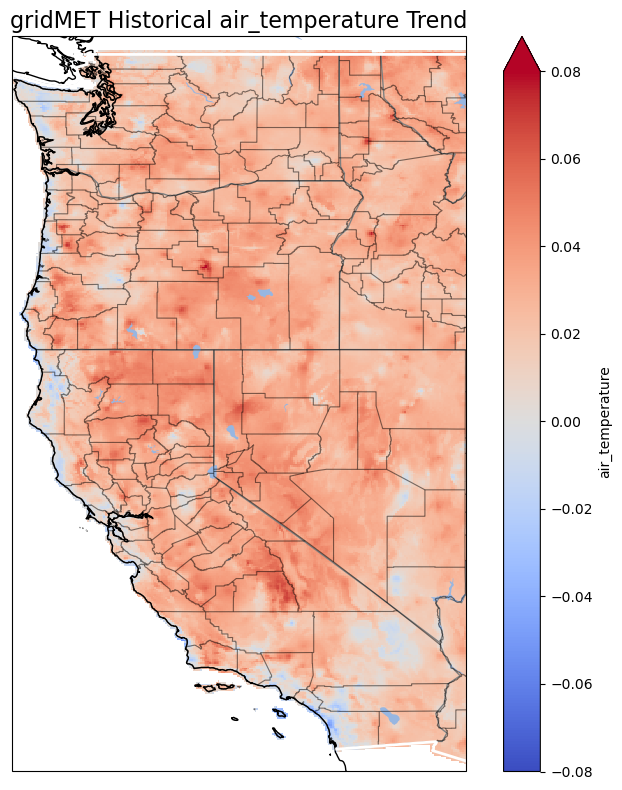

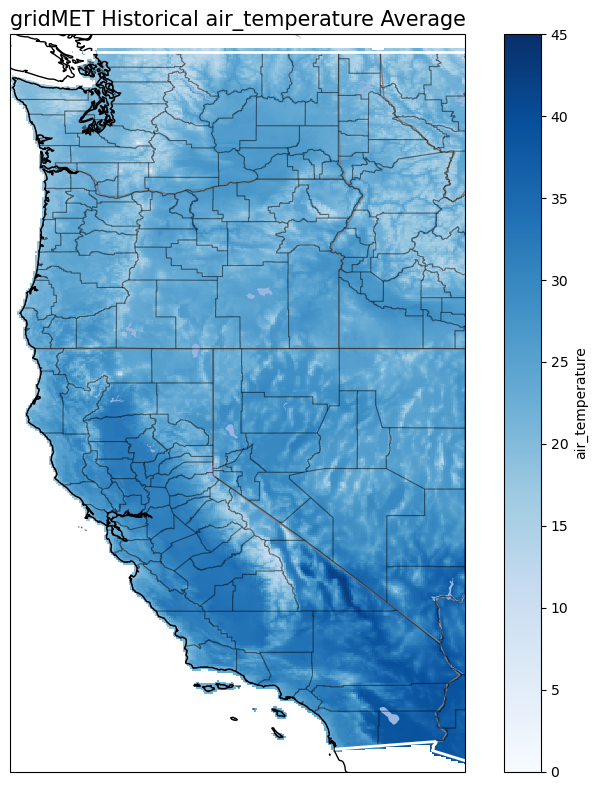

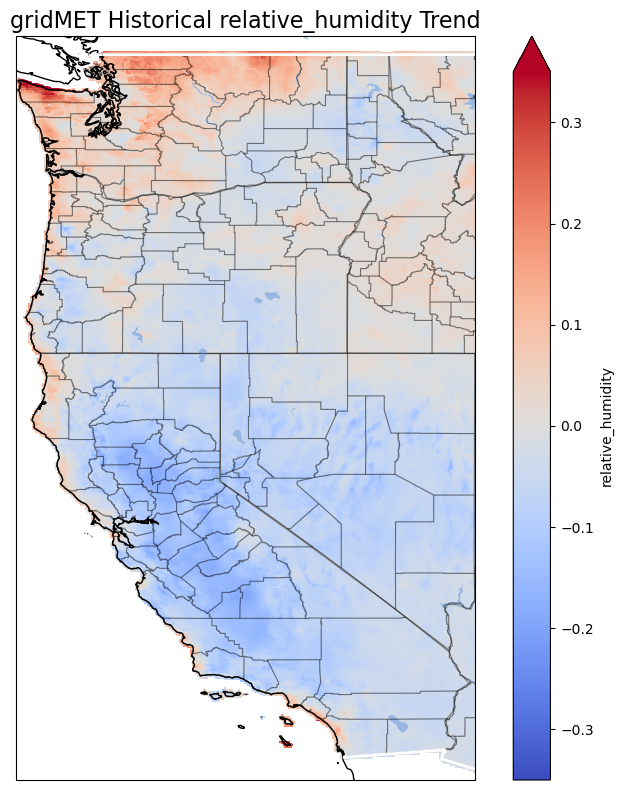

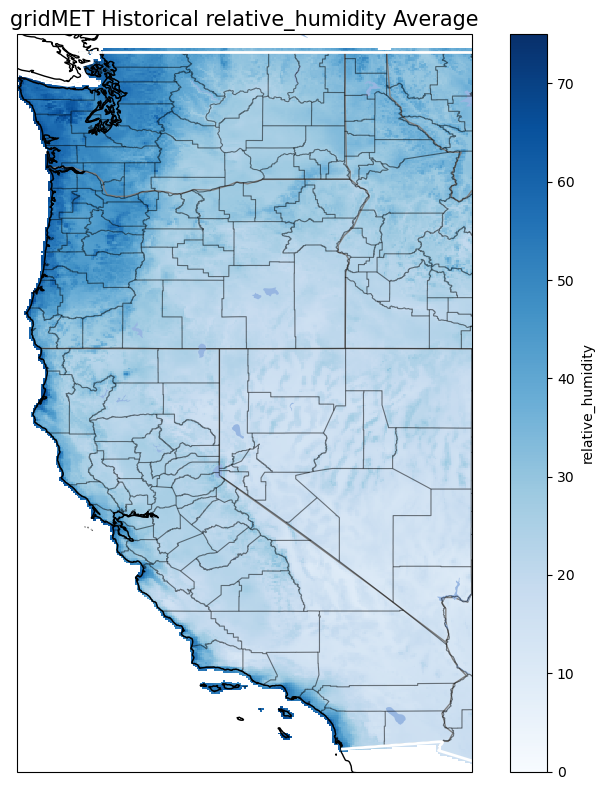

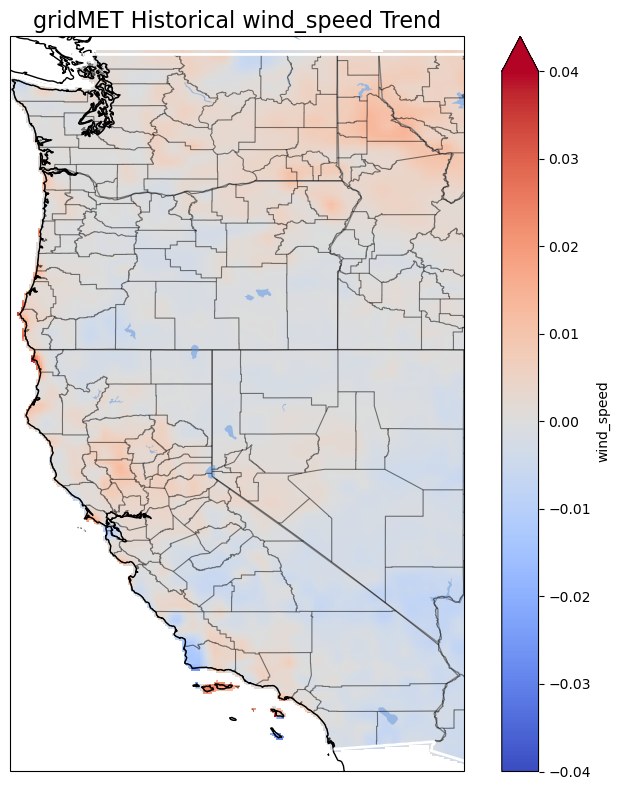

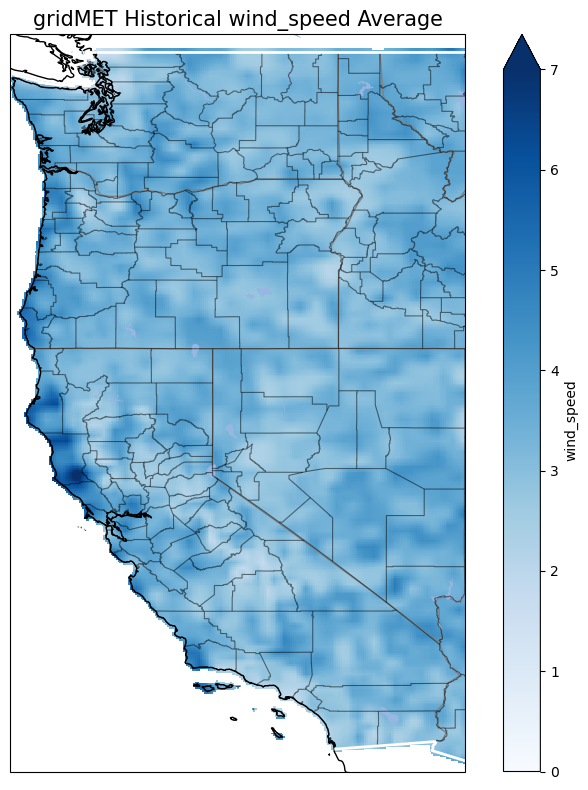

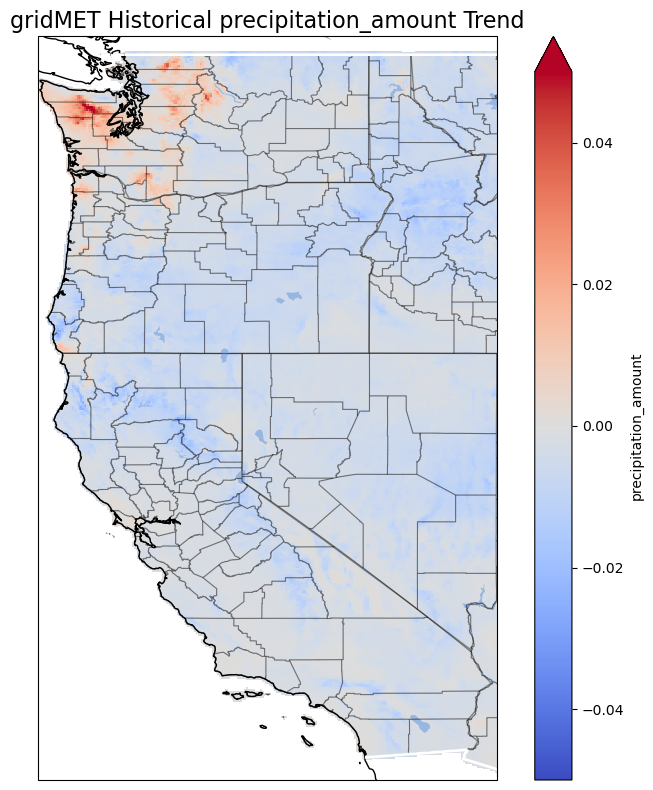

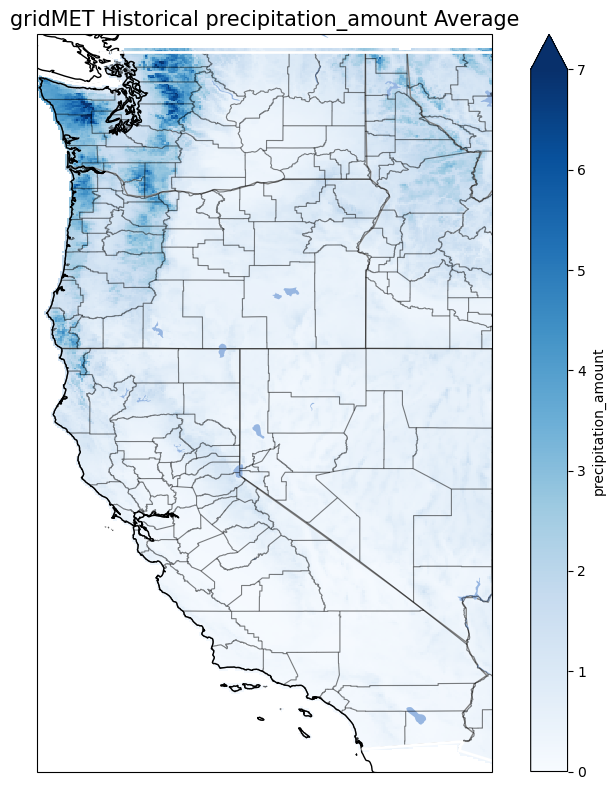

In [4]:
for var_i in var_arr:
    file_paths = sorted(glob.glob(f'{file_path+var_i}/*'))
    ds = xr.open_mfdataset(file_paths, combine="by_coords",chunks="auto")
    ds = ds.rename({'day':'time'})
    ds = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))

    mask = (ds["time"].dt.dayofyear >= start_day) & (ds["time"].dt.dayofyear <= end_day)
    ds = ds.where(mask, drop=True)

    ds_annual = ds.groupby("time.year").mean(dim="time")
    ds_annual = ds_annual.where((ds_annual.lon >= lon_min) & 
                                             (ds_annual.lon <= lon_max) & (ds_annual.lat >= lat_min) & (ds_annual.lat <= lat_max), drop=True)
    key = list(ds_annual.keys())[0]
    
    yearly_mean = ds_annual.mean(dim='year')
    poly_coeffs = ds_annual[key].polyfit(dim="year", deg=1)
    poly_coeffs_key = list(poly_coeffs.keys())[0]
    poly_coeffs = poly_coeffs.rename({poly_coeffs_key:key})
    poly_fits = xr.polyval(coord=ds_annual["year"], coeffs=poly_coeffs)
    trendline=  poly_coeffs.sel(degree=1)[key]
    #trendline_values = trendline * ds_annual["year"] + poly_coeffs.sel(degree=0)[key] 
    reader = shpreader.Reader('/data/keeling/a/ctavila2/2_maps/county_shapefile/countyl010g.shp')
    counties = list(reader.geometries())
    
    COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())
    
    scale = '110m'
    states110 = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_1_states_provinces_lines',
                scale=scale,
                facecolor='none',
                edgecolor='r')
    
    
    cmap='coolwarm'
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    if key == 'air_temperature':
        vmin = -0.08
        vmax = 0.08

    if key == 'relative_humidity':
        vmin = -0.35
        vmax = 0.35

    if key == 'wind_speed':
        vmin = -0.04
        vmax = 0.04

    if key == 'precipitation_amount':
        vmin = -0.05
        vmax = 0.05
        
    trendline.plot(ax=ax,cmap=cmap, vmin=vmin, vmax=vmax)
    
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
    ax.coastlines()
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')
    
    
    plt.title(f'gridMET Historical {key} Trend', fontsize=16)
    fig.tight_layout()
    plt.savefig(f'/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/revision_notebooks/revision_figures/1_gridMET_FWI_Inputs_{key}_1979_2022_Trend')
    reader = shpreader.Reader('/data/keeling/a/ctavila2/2_maps/county_shapefile/countyl010g.shp')
    counties = list(reader.geometries())
    
    COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())
    
    scale = '110m'
    states110 = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_1_states_provinces_lines',
                scale=scale,
                facecolor='none',
                edgecolor='r')
    
    
    cmap='Blues'
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    if key == 'air_temperature':
        yearly_mean = yearly_mean - 273.15
        vmin = 0.0
        vmax = 45.0

    if key == 'relative_humidity':
        vmin = 0.0
        vmax = 75.0

    if key == 'wind_speed':
        vmin = 0.0
        vmax = 7.0

    if key == 'precipitation_amount':
        vmin = 0.0
        vmax = 7.0
    
    yearly_mean[key].plot(ax=ax,cmap=cmap, vmin=vmin, vmax=vmax)
    
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
    ax.coastlines()
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')
    
    
    plt.title(f'gridMET Historical {key} Average', fontsize=15)
    fig.tight_layout()
    plt.savefig(f'/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/revision_notebooks/revision_figures/1_gridMET_FWI_Inputs_{key}_1979_2022_Average')